In [1]:
from langchain_deepseek import ChatDeepSeek
from dotenv import load_dotenv
from langgraph.types import Command,interrupt
from langgraph.checkpoint.memory import InMemorySaver,MemorySaver
from langgraph.constants import START,END
from langgraph.graph import StateGraph 
from typing import List, Dict, Any,TypedDict
from typing_extensions import Annotated
from langgraph.graph.message import add_messages
from langgraph.types import Send
import json_repair

load_dotenv()

True

In [ ]:
class Queries(BaseModel):
    queries: list[str]

In [2]:
llm = ChatDeepSeek(
    model="deepseek-chat",
    temperature=1,
    timeout=None,
    max_retries=2,
    )

class startState(TypedDict):
    messages: Annotated[list,add_messages]
    plan: str
    decision: str
class tempState(TypedDict):
    question: str

def generate_plan(state: startState) -> str:
    llm = ChatDeepSeek(
        model="deepseek-reasoner",
        temperature=1,
        timeout=None,
        max_retries=2,
        )
    # print( state["messages"][-1].content)
    # print( state["plan"])

    prompt = """
    you need generate a plan to answer the question: {question}

    you plan should be a json object with the following keys:
    - step1:
    - step2:
    - step3:
    """
    response = llm.invoke(prompt)
    import json_repair

    decoded_object = json_repair.loads(response.content)
    # print(response)
    return {'question': response.content,'plan': decoded_object,}

def just_q(state: tempState):
    result = interrupt(
        {
        'messages': 'do you agree with this',
        'the plan is: ':state['question']
        }
    )
    return {'decision': result['decision']}

def split_point(state: startState):
    print('this is the state')
    if state['decision'] == 'yes':
        return  [
        Send("acc_end", {'res':'good'})
    ]
    else:
        return  [
        Send("wa_end", {'res':'bad bda'})
    ]
     

def acc_end(input:dict):
    print(input)
    return 

def wa_end(input:dict):
    print(input)
    return 

builder = StateGraph(startState)
builder.add_node("generate_plan", generate_plan)
builder.add_node("just_q", just_q)
builder.add_node("acc_end", acc_end)
builder.add_node("wa_end", wa_end)


builder.add_edge(START, "generate_plan")
builder.add_edge("generate_plan", "just_q")
# builder.add_edge("just_q", END)
builder.add_conditional_edges(
    "just_q", split_point, ["acc_end","wa_end"]
)
builder.add_edge("acc_end", END)
builder.add_edge("wa_end", END)

checkpointer = InMemorySaver()

graph = builder.compile(name="pro-search-agent",checkpointer=checkpointer)


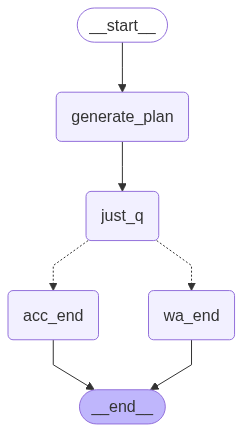

In [3]:
graph

In [4]:
config = {"configurable": {"thread_id": 'thread_1'}}

graph.invoke({"messages":   "how to build a DR which can write code to solve problems",},config=config)


APIConnectionError: Connection error.

In [5]:
edited_summary = "The cat lay on the rug, gazing peacefully at the night sky."
resumed_result = graph.invoke(
    Command(resume={"decision": 'yes'}),
    config=config
)

this is the state
{'res': 'good'}


In [6]:
resumed_result['plan']

{'step1': 'Understand and clarify the key elements of the question: {question}. Identify the main subject, required information type (e.g., factual, explanatory, comparative), and any ambiguous terms needing definition.',
 'step2': 'Gather relevant data or knowledge: Retrieve facts, concepts, or processes related to the question using reliable sources (e.g., academic databases, verified datasets, or established knowledge bases). Cross-reference information if needed.',
 'step3': 'Synthesize and structure the answer: Analyze the collected information for accuracy and relevance. Organize key points logically, address all parts of the question, and formulate a clear, concise response.'}

In [24]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    llm = ChatDeepSeek(
        model="deepseek-chat",
        temperature=1,
        timeout=None,
        max_retries=2,
        )
    response = llm.invoke(state["messages"])


    return {'messages':response.content}

builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

checkpointer = InMemorySaver()

graph = builder.compile(name="pro-search-agent",checkpointer=checkpointer)


In [25]:
config = {"configurable": {"thread_id": 'thread_1'}}
user_input = 'my name is liang, I want to have a conversation with you'
graph.invoke({"messages":  [{'role':'user','content':user_input}],},config=config)


{'messages': [HumanMessage(content='my name is liang, I want to have a conversation with you', additional_kwargs={}, response_metadata={}, id='b0930349-7026-411d-b95c-cdaa2b9be7c1'),
  HumanMessage(content="Hello, Liang! It's nice to meet you. 😊 What would you like to talk about today? I'm happy to chat about anything—your interests, hobbies, questions you have, or even just random thoughts. Let me know what's on your mind!  \n\n(For example: Are you into music, books, or tech? Or maybe you'd like help with something?)  \n\nLooking forward to our conversation!", additional_kwargs={}, response_metadata={}, id='185a5a48-f408-4a47-9aff-e30ee9d76e38')]}

In [26]:
config = {"configurable": {"thread_id": 'thread_1'}}
user_input = 'do you remember my name?'
graph.invoke({"messages":  [{'role':'user','content':user_input}],},config=config)

{'messages': [HumanMessage(content='my name is liang, I want to have a conversation with you', additional_kwargs={}, response_metadata={}, id='b0930349-7026-411d-b95c-cdaa2b9be7c1'),
  HumanMessage(content="Hello, Liang! It's nice to meet you. 😊 What would you like to talk about today? I'm happy to chat about anything—your interests, hobbies, questions you have, or even just random thoughts. Let me know what's on your mind!  \n\n(For example: Are you into music, books, or tech? Or maybe you'd like help with something?)  \n\nLooking forward to our conversation!", additional_kwargs={}, response_metadata={}, id='185a5a48-f408-4a47-9aff-e30ee9d76e38'),
  HumanMessage(content='do you remember my name?', additional_kwargs={}, response_metadata={}, id='232f35b4-e4a5-457d-984b-ed13bfb02a27'),
  HumanMessage(content='Yes, of course! Your name is **Liang**—you mentioned it at the start of our conversation. 😊 I’ll do my best to remember it for as long as we’re chatting (though if you leave and co